# GAN IN ACTION

#### P.57

#### 잠재 공간을 기반으로 손글씨 숫자를 생성하기.

2-1 기본 임포트

In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

2-2 하이퍼 파라미터 설정하기

In [2]:
batch_size = 100
original_dim = 784          #MNIST 이미지의 높이 X 너비
latent_dim = 2
intermediate_dim = 256
epochs = 50                 #에포크 회수
epsilon_std = 1.0

note : 함수형 API는 파이썬의 특수 메서드인 __call__() 메서드를 사용한다. 이 메서드는 객체를 함수처럼 사용할 때 호출된다.

2-3 인코더 만들기

In [3]:
x = Input(shape = (original_dim,), name = 'input')                          #인코더 입력
h = Dense(intermediate_dim, activation = 'relu', name = 'encoding')(x)      #중간층
z_mean = Dense(latent_dim, name = "mean")(h)                                #잠재 공간의 평균 정의
z_log_var = Dense(latent_dim, name = "log-variance")(h)                     #잠재 공간의 로그 분산 정의

z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])     #텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아니다.

encoder = Model(x, [z_mean, z_log_var, z], name = "encoder")                #케라스 모델로 인코더를 정의

NameError: name 'sampling' is not defined

2-4 샘플링 함수 만들기

In [4]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = epsilon_std)
    
    return z_mean + K.exp(z_log_var / 2) * epsilon

책 내용 코드 순서가 잘못된 듯 하다. smapling 함수 먼저 정의할 것

In [5]:
x = Input(shape = (original_dim,), name = 'input')                          #인코더 입력
h = Dense(intermediate_dim, activation = 'relu', name = 'encoding')(x)      #중간층
z_mean = Dense(latent_dim, name = "mean")(h)                                #잠재 공간의 평균 정의
z_log_var = Dense(latent_dim, name = "log-variance")(h)                     #잠재 공간의 로그 분산 정의

z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])     #텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아니다.

encoder = Model(x, [z_mean, z_log_var, z], name = "encoder")                #케라스 모델로 인코더를 정의

2-5 디코더 만들기

In [6]:
input_decoder = Input(shape=(latent_dim,), name = 'decoder_input')                             #디코더 입력
decoder_h = Dense(intermediate_dim, activation = 'relu', name = 'decoder_h')(input_decoder)    #잠재 공간을 중간층의 차원으로 변환
x_decoded = Dense(original_dim, activation = 'sigmoid', name = 'flat_decoded')(decoder_h)      #원본 차원으로 변환
decoder = Model(input_decoder, x_decoded, name = "decoder")                                    #케라스 모델로 디코더를 정의

2-6 모델 결합

In [7]:
output_combined = decoder(encoder(x)[2])      #인코더의 출력을 디코더에 사용
vae = Model(x, output_combined)               #인코더의 3번째 반환 값이 z이다.
vae.summary()                                 #모델 구조를 출력

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


2-7  손실 함수 정의

In [8]:
kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss = 'binary_crossentropy')       #마지막으로 모델을 컴파일.

note : 상대적 엔트로피relative entropy라고도 부르는 KL발산은 두 분포 간의 교차 엔트로피와 자기 자신의 엔트로피 간의 차이를 측정하는 것.\
정보 이론에 익숙하지 않다면 두 분포를 그렸을 때 겹치지 않는 부분이 KL 발산에 비례하는 면적이라고 이해하면 된다.

note : 확률적 경사 하강법은 오차에 기여한 정도를 바탕으로 가중치를 업데이트하여(예측이 100% 맞았을 경우 업데이트 되지 않는다.) 복잡한 모델을 훈련할 수 있는 최적화 기법이다.\
이와 관련해서 케라스 창시자에게 배우는 딥러닝을 참고할 것.

2-8 훈련/테스트 세트 분할하기

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [12]:
vae.fit(x_train, x_train, shuffle=True, epochs = epochs, batch_size = batch_size)

Epoch 1/50
600/600 [==============================] - 5s 6ms/step - loss: 0.2871
Epoch 2/50
600/600 [==============================] - 3s 6ms/step - loss: 0.2444
Epoch 3/50
600/600 [==============================] - 3s 6ms/step - loss: 0.2389
Epoch 4/50
600/600 [==============================] - 3s 6ms/step - loss: 0.2342
Epoch 5/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2304
Epoch 6/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2277
Epoch 7/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2257
Epoch 8/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2242
Epoch 9/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2229
Epoch 10/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2217
Epoch 11/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2206
Epoch 12/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2196
Epoch 13/50
600/600 [====

313/313 [==============================] - 1s 2ms/step


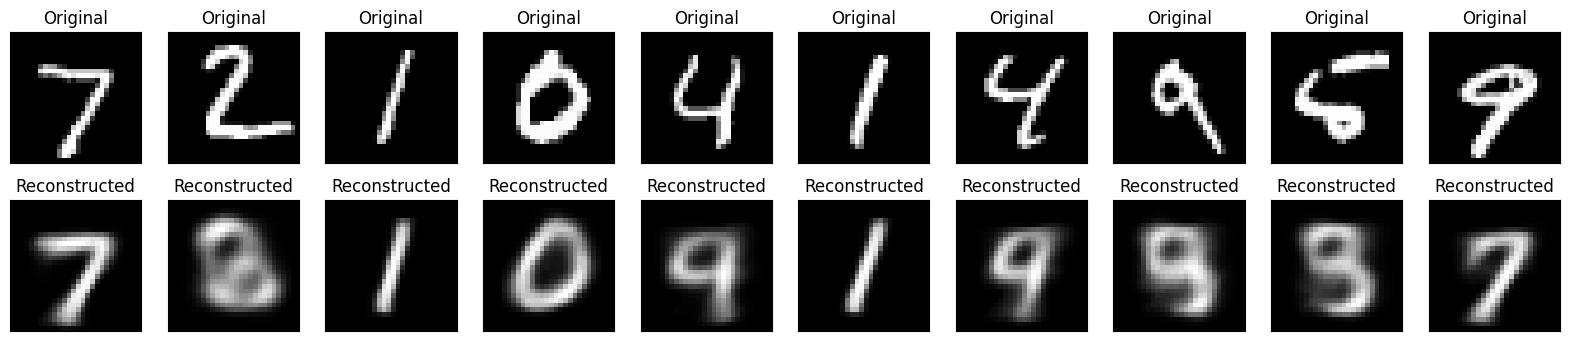

KeyError: 'loss'

In [13]:
import matplotlib.pyplot as plt

# Generate reconstructed images
decoded_imgs = vae.predict(x_test)

# Function to plot original and reconstructed images
def plot_images(original_imgs, reconstructed_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Plot original and reconstructed images
plot_images(x_test, decoded_imgs)

# Plot loss function during training
loss = vae.history.history['loss']
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 0.1990
Epoch 2/50
600/600 [==============================] - 4s 6ms/step - loss: 0.1988
Epoch 3/50
600/600 [==============================] - 4s 6ms/step - loss: 0.1985
Epoch 4/50
600/600 [==============================] - 4s 6ms/step - loss: 0.1983
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1980
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 0.1978
Epoch 7/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1976
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 0.1974
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 0.1972
Epoch 10/50
600/600 [==============================] - 4s 7ms/step - loss: 0.1970
Epoch 11/50
600/600 [==============================] - 4s 7ms/step - loss: 0.1968
Epoch 12/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1966
Epoch 13/50
600/600 [====

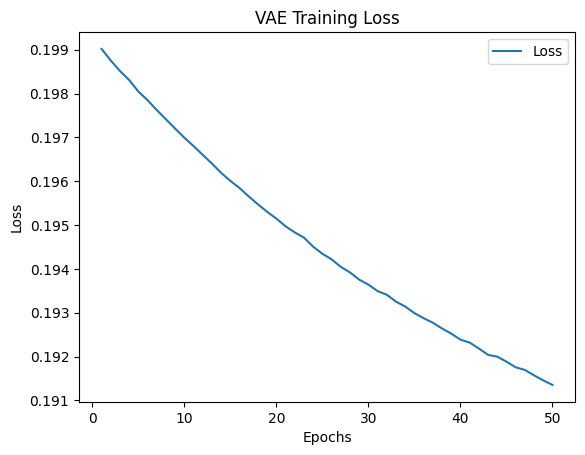

In [15]:
history = vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

# Generate reconstructed images
decoded_imgs = vae.predict(x_test)

# Function to plot original and reconstructed images
def plot_images(original_imgs, reconstructed_imgs, n=10):
    # Same plotting code as before

# Plot original and reconstructed images
    plot_images(x_test, decoded_imgs)

# Plot loss function during training
loss = history.history['loss']
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()


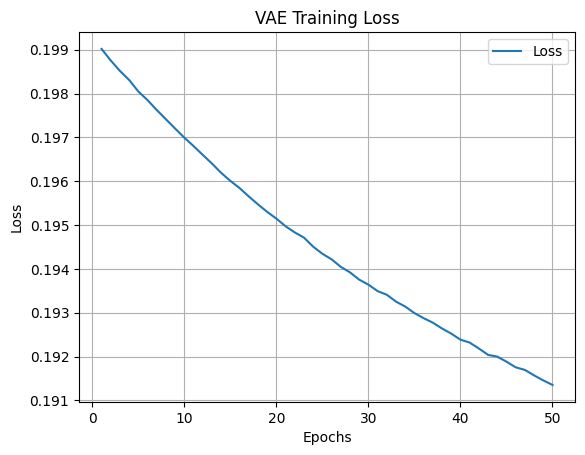

In [16]:
plt.plot(epochs_range, loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid()
plt.legend()
plt.show()


313/313 [==============================] - 1s 2ms/step


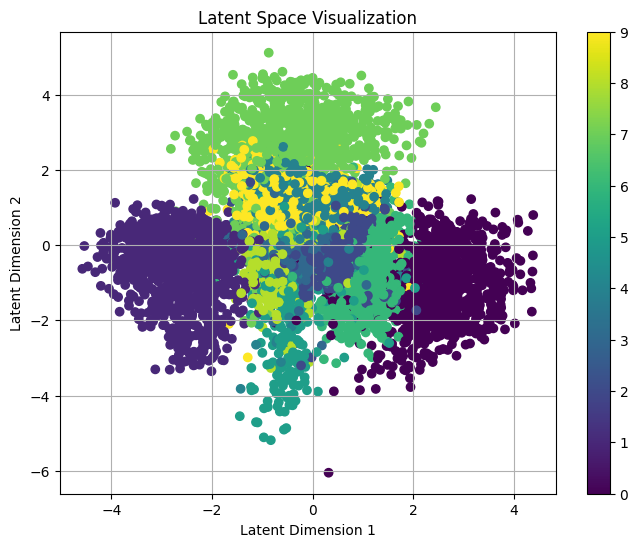

In [21]:
# Encode the test images to get the latent space representations
_, _, encoded_imgs = encoder.predict(x_test)

# Function to plot the latent space
def plot_latent_space(encoded_imgs, y_test):
    plt.figure(figsize=(8, 6))
    plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, cmap='viridis')
    plt.colorbar()
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.grid()
    plt.show()

plot_latent_space(encoded_imgs, y_test)


그림 2-6 \
테스트 세트의 모든 포인트를 잠재 공간으로 클래스를 유지하면서 이차원 투영\
이 그림은 2차원 잠재 공간을 그래프에 보여준다, 우측의 범례에 맞춰 생성된 샘플의 클래스를 색으로 표현, 클래스별로 잘 무리지어있으므로 이 잠재공간은 좋은 표현이다.